In [1]:
import warnings

def no_warning(*args, **kwargs):
    pass

warnings.warn = no_warning  # 모든 경고 무력화

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from IPython.display import display
from pprint import pprint
import os
import sys

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from iblatlas.atlas import AllenAtlas
from one.api import ONE

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"BASE_DIR: {BASE_DIR}")

RESULT_DIR = os.path.join(BASE_DIR, 'result', 'VISp', 'lateralization')

def add_module_paths(base, *rel_paths):
    for rel_path in rel_paths:
        sys.path.append(os.path.join(base, *rel_path))

add_module_paths(BASE_DIR,
    ['func'],               # func 바로 아래 함수들
    ['func', 'compute'],
    ['func', 'info'],
    ['func', 'plot']
)

from print_cluster_info import print_cluster_info
from get_trial_masks import get_trial_masks
from compute_raster import compute_raster
from compute_psth import compute_psth
from plot_raster import plot_raster
from plot_psth_2x2 import plot_psth_2x2
from plot_psth_contrast import plot_psth_contrast
from plot_psth_1 import plot_psth_left_vs_right
from sub_func import save_file


BASE_DIR: c:\Users\miasc\SCH\shinlab\IBL\VISp_PSTH


In [3]:
# -----------------------------------------------------------------------------
# 1. ONE 초기화 및 인설션 검색(유연한 brain_acronym)
# -----------------------------------------------------------------------------
# 원하는 뇌영역 문자열을 지정(예: 'VISp', 'MOs' 등)

one = ONE()

insertions_dict = {}

for brain_acronym in ['VISp', 'VISl', 'VISal', 'VISam', 'VISpm', 'VISrl']:
    insertions = one.search_insertions(atlas_acronym=brain_acronym) # probe 기준으로 search 됨
    insertions_dict[brain_acronym] = list(set(insertions)) # 중복 제거
    print(f"\n[{brain_acronym}] Detected insertions: {len(set(insertions))}") 

# 겹치는 인설션들만 찾기
insertions_VISp_VISl = set(insertions_dict['VISp']).intersection(set(insertions_dict['VISl']))
print(f"\n🔍 {len(insertions_VISp_VISl)} insertions found in both VISp and VISl regions.")
insertions_VISp_VISpm = set(insertions_dict['VISp']).intersection(set(insertions_dict['VISpm']))
print(f"\n🔍 {len(insertions_VISp_VISpm)} insertions found in both VISp and VISpm regions.")
insertions_VISal_VISp_VISrl = set(insertions_dict['VISal']).intersection(set(insertions_dict['VISp'])).intersection(set(insertions_dict['VISrl']))
print(f"\n🔍 {len(insertions_VISal_VISp_VISrl)} insertions found in VISal, VISp, and VISrl regions.")



[VISp] Detected insertions: 73

[VISl] Detected insertions: 15

[VISal] Detected insertions: 5

[VISam] Detected insertions: 35

[VISpm] Detected insertions: 29

[VISrl] Detected insertions: 9

🔍 5 insertions found in both VISp and VISl regions.

🔍 11 insertions found in both VISp and VISpm regions.

🔍 1 insertions found in VISal, VISp, and VISrl regions.


<Figure size 1200x600 with 0 Axes>

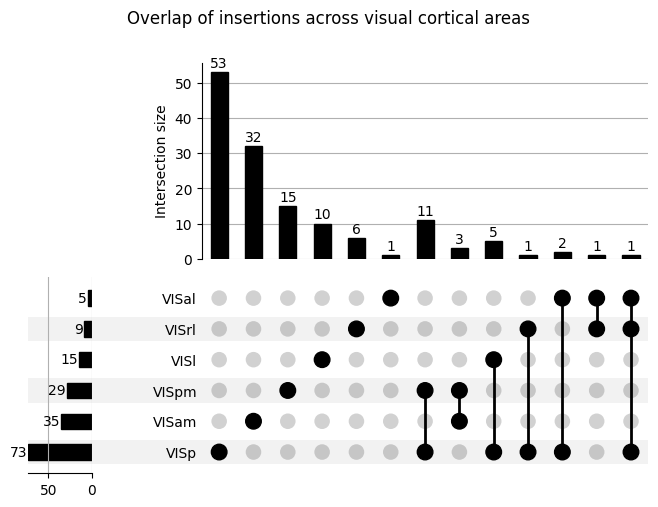

In [4]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# 각 인설션이 어떤 영역에 포함되는지 추적
from collections import defaultdict

insertion_to_areas = defaultdict(set)
for area, insertion_ids in insertions_dict.items():
    for sid in list(insertion_ids):  # Lazy 객체라면 list 변환
        insertion_to_areas[sid].add(area)

# 인설션별 포함 관계 → UpSet용 데이터로 변환
memberships = [tuple(sorted(areas)) for areas in insertion_to_areas.values()]
data = from_memberships(memberships)

# 시각화
plt.figure(figsize=(12, 6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.suptitle("Overlap of insertions across visual cortical areas")
plt.show()


In [5]:
# insertion_dict 내 insertion들을 모두 합쳐서, 중복 값이 존재하는지 여부 확인

from collections import defaultdict, Counter

# (1) 인설션 ID를 영역별로 추적
insertion_to_regions = defaultdict(set)

for region, insertion_list in insertions_dict.items():
    for insertion in list(insertion_list):  # <- Lazy 객체를 명시적으로 리스트로 변환
        insertion_to_regions[insertion].add(region)

# (2) 등장 횟수 세기
insertions_counts = Counter()

for insertions in insertions_dict.values():
    insertions_counts.update(list(insertions))  # <- 여기도 변환 필요

# (3) 중복 인설션 + 해당 영역 출력
duplicate_insertions = {sess for sess, count in insertions_counts.items() if count > 1}

if duplicate_insertions:
    print(f"🔁 중복된 인설션이 {len(duplicate_insertions)}개 있습니다:\n")
    for ins in sorted(duplicate_insertions):
        regions = sorted(insertion_to_regions[ins])
        print(f"- 인설션 {ins} ➜ 영역들: {', '.join(regions)}")
else:
    print("✅ 중복된 인설션은 없습니다.")

# insertions_dict: { 'VISp': [...], 'VISal': [...], ... } 형태

# # 모든 pid를 하나의 리스트로 모으기
# insertions = []
# for pid_list in insertions_dict.values():
#     insertions.extend(pid_list)

# insertions = list(set(insertions)) # 중복 제거
# print(f"총 {len(insertions)}개의 unique insertion PID가 수집되었습니다.")

# insertions = insertions[:5]
# pprint(insertions)

🔁 중복된 인설션이 24개 있습니다:

- 인설션 0393f34c-a2bd-4c01-99c9-f6b4ec6e786d ➜ 영역들: VISam, VISpm
- 인설션 0a0184b3-9e1a-4c36-98f4-00ae3beb8f01 ➜ 영역들: VISl, VISp
- 인설션 12c0f3a9-518e-4dac-9651-5d95c2b4730f ➜ 영역들: VISl, VISp
- 인설션 18d316bf-d322-4c5c-814e-a58147f7bf5f ➜ 영역들: VISal, VISp
- 인설션 220bca21-4cf8-43f1-a213-71645899c571 ➜ 영역들: VISp, VISrl
- 인설션 478de1ce-d7e7-4221-9365-2abdc6e88fb6 ➜ 영역들: VISp, VISpm
- 인설션 4836a465-c691-4852-a0b1-dcd2b1ce38a1 ➜ 영역들: VISp, VISpm
- 인설션 5246af08-0730-40f7-83de-29b5d62b9b6d ➜ 영역들: VISam, VISpm
- 인설션 5544da75-8d34-47cb-9092-1f91e713e79c ➜ 영역들: VISal, VISp, VISrl
- 인설션 69f42a9c-095d-4a25-bca8-61a9869871d3 ➜ 영역들: VISam, VISpm
- 인설션 7f3dddf8-637f-47bb-a7b7-e303277b2107 ➜ 영역들: VISp, VISpm
- 인설션 85bdeae3-269b-4e39-bd9b-2b0d95aff2fa ➜ 영역들: VISl, VISp
- 인설션 9e069684-a4be-4b70-b9e6-446309f977d4 ➜ 영역들: VISal, VISrl
- 인설션 a6fe3779-2b77-4b66-a625-a6078720e412 ➜ 영역들: VISp, VISpm
- 인설션 a8a59fc3-a658-4db4-b5e8-09f1e4df03fd ➜ 영역들: VISp, VISpm
- 인설션 afecbc7f-10e3-40af-b091-cca9e8df61

In [ ]:
i = 1

for pid in insertions:

    # Spike Sorting 데이터
    ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    clusters = pd.DataFrame(clusters)

    # -----------------------------------------------------------------------------
    # 클러스터 정보 출력
    # ----------------------------------------------------------------------------- 
    print(f"\nNo. of clusters from probe {i}: {len(clusters)}")
    unique_acronyms = np.unique(clusters['acronym'])
    print(f"\n🧠 probe {i} covers : \n{unique_acronyms}\n")

    # print("   [[[   Cluster Info   ]]]")
    # clusters_good = {k: v[clusters['label'] == 1] for k, v in clusters.items()} # Good clusters만 추출
    # print_cluster_info(clusters, clusters_good)
    i += 1


No. of clusters from probe 1: 1002

🧠 probe 1 covers : 
['AUDpo6a' 'AUDpo6b' 'CA1' 'ECT6a' 'ENTl3' 'ENTl5' 'PERI5' 'PERI6a'
 'VISal4' 'VISal5' 'VISal6a' 'VISp1' 'VISp2/3' 'VISrl2/3' 'VISrl4' 'alv'
 'ec' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [197 | 1002]

No. of clusters in each region:
AUDpo6a: 8 | 26
AUDpo6b: 10 | 29
CA1: 2 | 25
ECT6a: 4 | 12
ENTl3: 11 | 71
ENTl5: 25 | 97
PERI5: 8 | 27
PERI6a: 21 | 54
VISal4: 9 | 41
VISal5: 26 | 102
VISal6a: 9 | 81
VISp1: 0 | 3
VISp2/3: 0 | 4
VISrl2/3: 0 | 32
VISrl4: 1 | 19
alv: 5 | 51
ec: 33 | 138
fp: 6 | 87
or: 19 | 103

No. of clusters from probe 2: 898

🧠 probe 2 covers : 
['CA1' 'CA3' 'DG-mo' 'DG-sg' 'LGd-co' 'LGd-ip' 'LGd-sh' 'MGv' 'TH' 'VISa1'
 'VISrl2/3' 'VISrl4' 'VISrl5' 'VISrl6a' 'VISrl6b' 'alv' 'ccs'
 'fiber tracts' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [76 | 898]

No. of clusters in each region:
CA1: 1 | 92
CA3: 1 | 23
DG-mo: 0 | 18
DG-sg: 1 | 9
LGd


brain_region : VISp

🔍 [probe 1], pid = 5544da75-8d34-47cb-9092-1f91e713e79c
>> 7 cluster found.


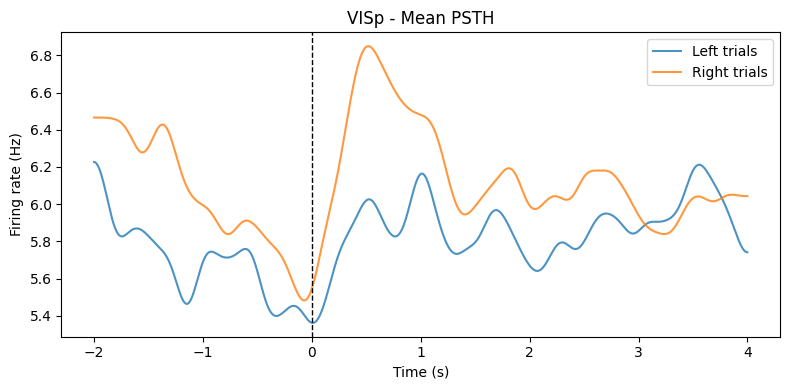

🔍 [probe 2], pid = 56f2a378-78d2-4132-b3c8-8c1ba82be598
>> 0 cluster found.
🔍 [probe 3], pid = 220bca21-4cf8-43f1-a213-71645899c571
>> 13 cluster found.


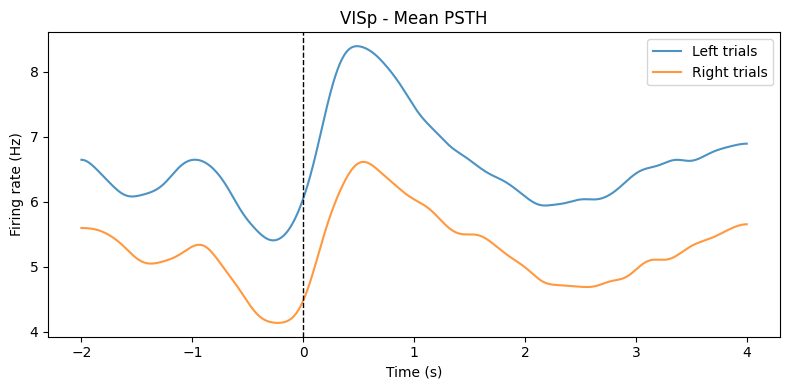

🔍 [probe 4], pid = 8fbfa285-d721-4a1a-8c18-f36652c17909


local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


>> 0 cluster found.
🔍 [probe 5], pid = 31811232-52ef-456c-9772-5021c00b2bc9


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS016\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.69k/3.69k [00:00<00:00, 7.73kB/s]


>> 0 cluster found.
🔍 [probe 6], pid = 70da415f-444d-4148-ade7-a1f58a16fcf8
>> 0 cluster found.
🔍 [probe 7], pid = eb99c2c8-e614-4240-931b-169bed23e9f5
>> 0 cluster found.
🔍 [probe 8], pid = 0eb65305-bb95-4bf1-a154-1b810c0cff25
>> 0 cluster found.
🔍 [probe 9], pid = 9e069684-a4be-4b70-b9e6-446309f977d4
>> 0 cluster found.

brain_region : VISl

🔍 [probe 1], pid = 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 cluster found.
🔍 [probe 2], pid = 56f2a378-78d2-4132-b3c8-8c1ba82be598
>> 0 cluster found.
🔍 [probe 3], pid = 220bca21-4cf8-43f1-a213-71645899c571
>> 0 cluster found.
🔍 [probe 4], pid = 8fbfa285-d721-4a1a-8c18-f36652c17909


local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


>> 0 cluster found.
🔍 [probe 5], pid = 31811232-52ef-456c-9772-5021c00b2bc9


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS016\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.69k/3.69k [00:00<00:00, 6.43kB/s]


>> 0 cluster found.
🔍 [probe 6], pid = 70da415f-444d-4148-ade7-a1f58a16fcf8
>> 0 cluster found.
🔍 [probe 7], pid = eb99c2c8-e614-4240-931b-169bed23e9f5
>> 0 cluster found.
🔍 [probe 8], pid = 0eb65305-bb95-4bf1-a154-1b810c0cff25
>> 0 cluster found.
🔍 [probe 9], pid = 9e069684-a4be-4b70-b9e6-446309f977d4
>> 0 cluster found.
VISl : No valid spike raster found.

brain_region : VISal

🔍 [probe 1], pid = 5544da75-8d34-47cb-9092-1f91e713e79c
>> 224 cluster found.


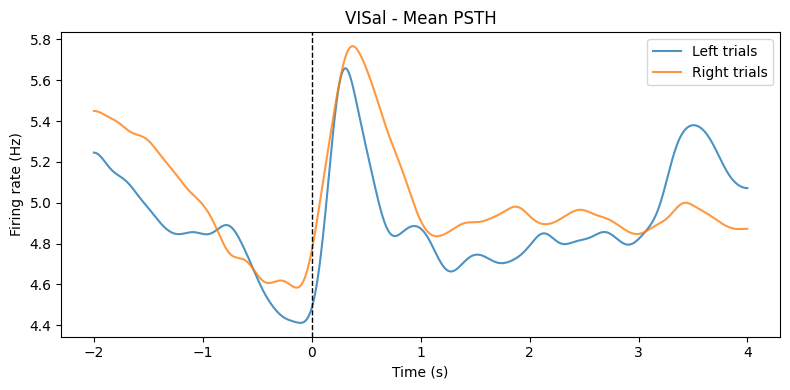

🔍 [probe 2], pid = 56f2a378-78d2-4132-b3c8-8c1ba82be598
>> 0 cluster found.
🔍 [probe 3], pid = 220bca21-4cf8-43f1-a213-71645899c571
>> 0 cluster found.
🔍 [probe 4], pid = 8fbfa285-d721-4a1a-8c18-f36652c17909


local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


>> 0 cluster found.
🔍 [probe 5], pid = 31811232-52ef-456c-9772-5021c00b2bc9


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS016\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.69k/3.69k [00:00<00:00, 8.37kB/s]


>> 0 cluster found.
🔍 [probe 6], pid = 70da415f-444d-4148-ade7-a1f58a16fcf8
>> 0 cluster found.
🔍 [probe 7], pid = eb99c2c8-e614-4240-931b-169bed23e9f5
>> 0 cluster found.
🔍 [probe 8], pid = 0eb65305-bb95-4bf1-a154-1b810c0cff25
>> 0 cluster found.
🔍 [probe 9], pid = 9e069684-a4be-4b70-b9e6-446309f977d4
>> 210 cluster found.


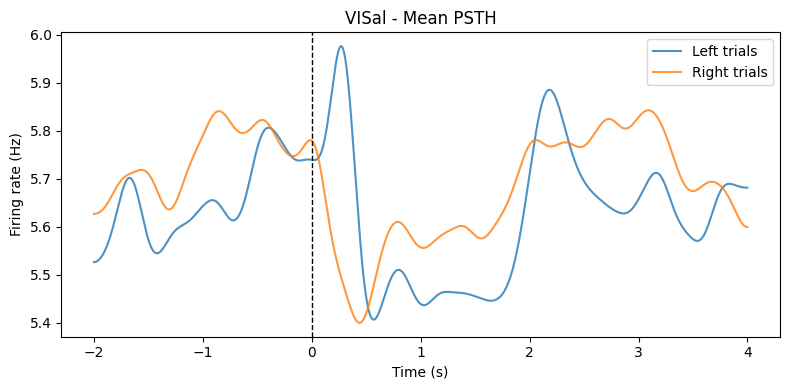


brain_region : VISpm

🔍 [probe 1], pid = 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 cluster found.
🔍 [probe 2], pid = 56f2a378-78d2-4132-b3c8-8c1ba82be598
>> 0 cluster found.
🔍 [probe 3], pid = 220bca21-4cf8-43f1-a213-71645899c571
>> 0 cluster found.
🔍 [probe 4], pid = 8fbfa285-d721-4a1a-8c18-f36652c17909


local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


>> 0 cluster found.
🔍 [probe 5], pid = 31811232-52ef-456c-9772-5021c00b2bc9


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS016\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.69k/3.69k [00:00<00:00, 6.60kB/s]


>> 0 cluster found.
🔍 [probe 6], pid = 70da415f-444d-4148-ade7-a1f58a16fcf8
>> 0 cluster found.
🔍 [probe 7], pid = eb99c2c8-e614-4240-931b-169bed23e9f5
>> 0 cluster found.
🔍 [probe 8], pid = 0eb65305-bb95-4bf1-a154-1b810c0cff25
>> 0 cluster found.
🔍 [probe 9], pid = 9e069684-a4be-4b70-b9e6-446309f977d4
>> 0 cluster found.
VISpm : No valid spike raster found.

brain_region : VISrl

🔍 [probe 1], pid = 5544da75-8d34-47cb-9092-1f91e713e79c
>> 51 cluster found.


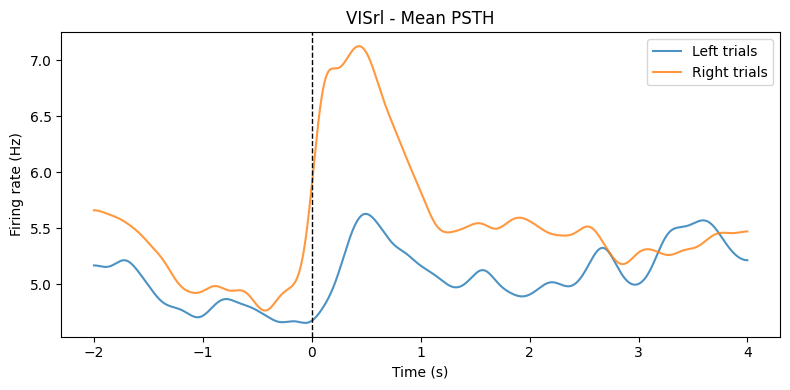

🔍 [probe 2], pid = 56f2a378-78d2-4132-b3c8-8c1ba82be598
>> 121 cluster found.


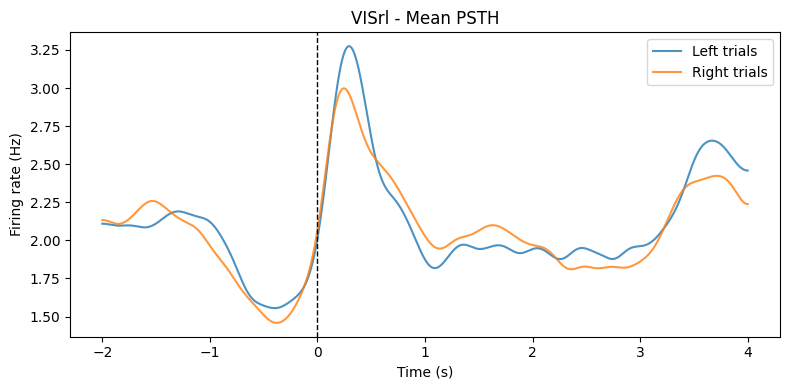

🔍 [probe 3], pid = 220bca21-4cf8-43f1-a213-71645899c571
>> 17 cluster found.


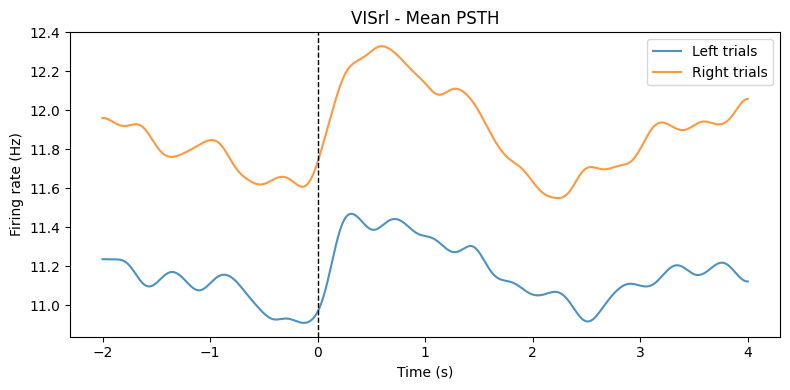

🔍 [probe 4], pid = 8fbfa285-d721-4a1a-8c18-f36652c17909
>> 219 cluster found.


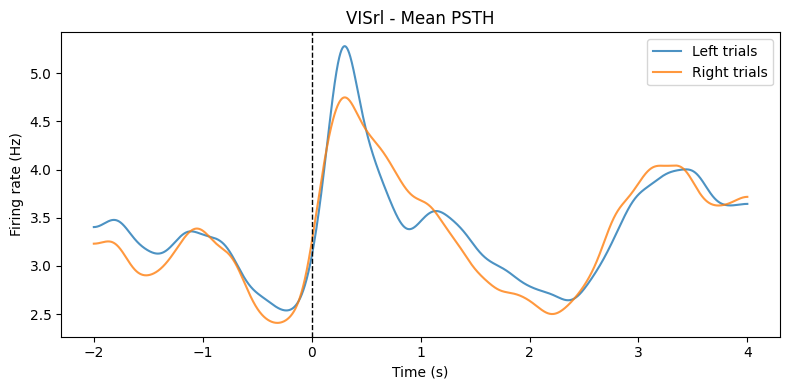

local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


🔍 [probe 5], pid = 31811232-52ef-456c-9772-5021c00b2bc9


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS016\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.69k/3.69k [00:00<00:00, 7.82kB/s]


>> 4 cluster found.


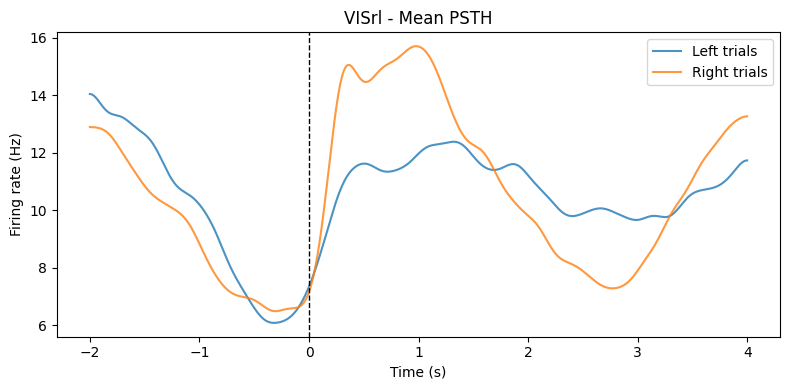

🔍 [probe 6], pid = 70da415f-444d-4148-ade7-a1f58a16fcf8
>> 21 cluster found.


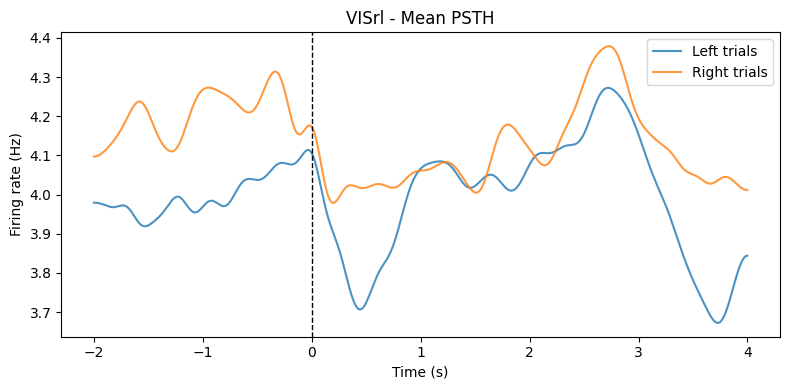

🔍 [probe 7], pid = eb99c2c8-e614-4240-931b-169bed23e9f5
>> 241 cluster found.


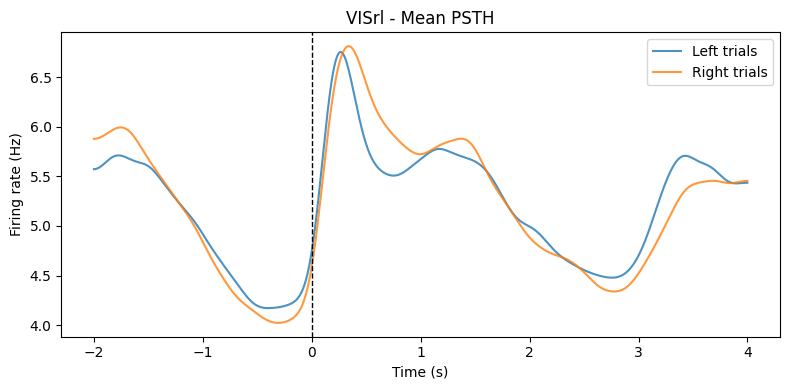

🔍 [probe 8], pid = 0eb65305-bb95-4bf1-a154-1b810c0cff25
>> 484 cluster found.


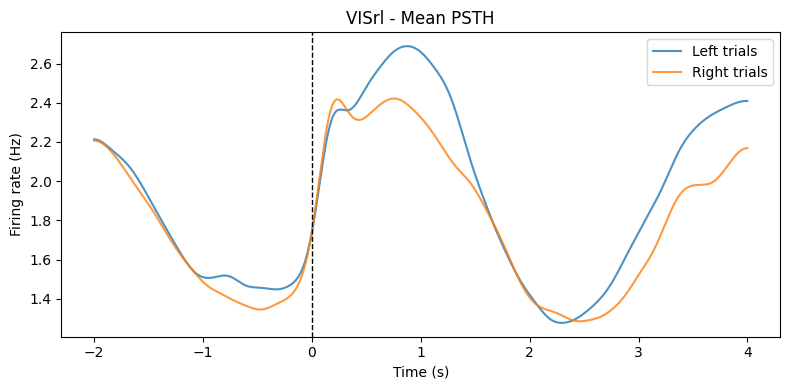

🔍 [probe 9], pid = 9e069684-a4be-4b70-b9e6-446309f977d4
>> 23 cluster found.


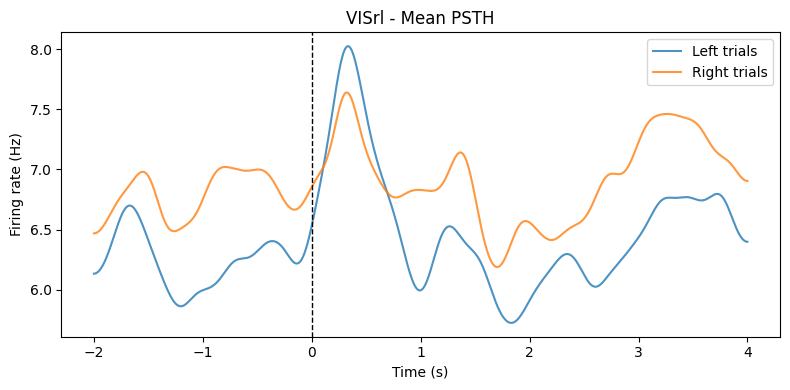

Done.


In [7]:
# -----------------------------------------------------------------------------
# 2. Trial / Spike data 로드 (SessionLoader, SpikeSortingLoader)
# -----------------------------------------------------------------------------


brain_region_list = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']

for brain_region, cluster_label in [(region, 'cluster') for region in brain_region_list]:
    print(f"\nbrain_region : {brain_region}\n")

    psth_left_list = []
    psth_right_list = []

    i = 1
    for pid in insertions_dict[region] :
        print(f"🔍 [probe {i}], pid = {pid}")
        i += 1

        # Trial 데이터
        eid, pname = one.pid2eid(pid)
        sl = SessionLoader(eid=eid, one=one)
        sl.load_trials()
        events = sl.trials['stimOn_times'].values
        left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

        # Spike Sorting 데이터
        ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
        spikes, clusters, channels = ssl.load_spike_sorting()
        clusters = ssl.merge_clusters(spikes, clusters, channels)
        clusters = pd.DataFrame(clusters)

        # -----------------------------------------------------------------------------
        # 3. 특정 영역(문자열 포함) Mask 정의 (모든 + good)
        # -----------------------------------------------------------------------------
        good_mask = (clusters['label'] == 1)

        if brain_region == 'VISp':
            region_mask = np.array(['VISp' in acr for acr in clusters['acronym']]) & ~np.array(['VISpm' in acr for acr in clusters['acronym']])
        else:
            region_mask = np.array([brain_region in acr for acr in clusters['acronym']])
        
        # selected_mask = region_mask & good_mask
        selected_mask = region_mask
        
        # -----------------------------------------------------------------------------
        # -----------------------------------------------------------------------------
        # 6. 두 가지 경우(모든 클러스터 / good 클러스터)에 대해 동일한 분석
        # -----------------------------------------------------------------------------
        
            
        selected_cluster_ids = np.where(selected_mask)[0] # 해당되는 클러스터 ID들.
        # print(f"\n🔍 Selected cluster IDs for {brain_region} ({cluster_label}): {selected_cluster_ids}")
        if cluster_label == "Single Cluster":
            selected_cluster_ids = [selected_cluster_ids[0]]

        n_clusters = len(selected_cluster_ids)
        print(f">> {n_clusters} {cluster_label} found.")
        if n_clusters == 0:
            continue
        else:
            spike_raster, times = compute_raster(spikes, selected_cluster_ids, events, pre_time=2, post_time=4, bin_size=0.001)
            psth_left = gaussian_filter1d(compute_psth(spike_raster, left_idx), sigma=100)
            psth_right = gaussian_filter1d(compute_psth(spike_raster, right_idx), sigma=100)

            psth_left_list.append(psth_left)
            psth_right_list.append(psth_right)

            # =======================
            # 각 영역별 Figure 출력
            # =======================
            plt.figure(figsize=(8, 4))
            plt.plot(times, psth_left, label='Left trials', alpha=0.8)
            plt.plot(times, psth_right, label='Right trials', alpha=0.8)
            plt.axvline(0, color='k', linestyle='--', linewidth=1)
            plt.title(f'{brain_region} - Mean PSTH')
            plt.xlabel('Time (s)')
            plt.ylabel('Firing rate (Hz)')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
                
    if len(psth_left_list + psth_right_list) == 0:
        print(f"{brain_region} : No valid spike raster found.")
        continue
    
    # (3) 배열 변환
    psth_left_list = np.array(psth_left_list)  # (npids_total, nBins)
    psth_right_list = np.array(psth_right_list)
    mean_psth_left = np.nanmean(psth_left_list, axis=0)  # shape = (nBins)
    mean_psth_right = np.nanmean(psth_right_list, axis=0)



plt.show(block=False) 
plt.close('all')
print("Done.")